In [91]:
import areia 
import numpy as np

from astropy.io import fits
from matplotlib import pyplot as plt

Testing AREIA for a source in the CANDELS GOODS-S field, in the F160W band

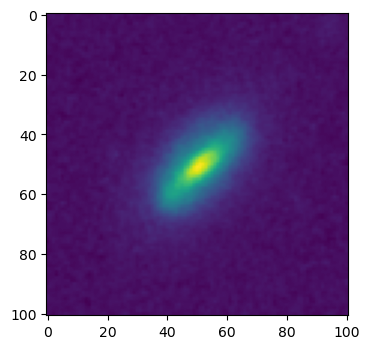

In [3]:
bright_galaxy = fits.getdata('example.fits')
psf = fits.getdata('psf.fits')

f = plt.subplots(1, dpi=100)
plt.imshow(bright_galaxy)

We define two frames, the initial and the target frame. The initial frame holds the true information of the observation and instrument setup while the target is the one to be simulated.

## Test flux preserved when changing pixel scale
Expectation: pixel scale doubled, but same source flux, so total counts/sec integrated over the source should be preserved. Flux in individual source pixels should increase by factor of four.

In [52]:
initial_frame = areia.ObservationFrame(0.1, pixelscale=0.06, exptime=5e4)
target_frame = areia.ObservationFrame(0.1, pixelscale=0.12, exptime=5e4)

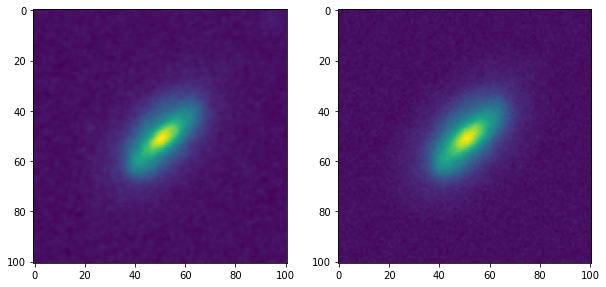

In [62]:
AR = areia.ArtificialRedshift(bright_galaxy, psf, None, initial_frame, target_frame)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
im1 = ax1.imshow(bright_galaxy)
vmin = bright_galaxy.min()
vmax = bright_galaxy.max()
ax1.imshow(bright_galaxy, vmin=vmin, vmax=vmax)
ax2.imshow(AR.final)

In [63]:
AR.cutout.sum(), AR.final.sum()

(124.06184, 124.18150255927726)

## Test flux preserved for 'identity' (but psf re-convolved)

Expectation: convolution should redistribute light, but not change the total light. Addition of noise should not change total flux systematically.

In [61]:
initial_frame = areia.ObservationFrame(0.1, pixelscale=0.06, exptime=5e4)
target_frame = areia.ObservationFrame(0.1, pixelscale=0.06, exptime=5e4)

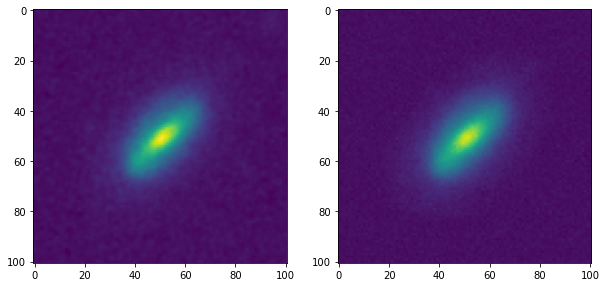

In [41]:
AR = areia.ArtificialRedshift(bright_galaxy, psf, None, initial_frame, target_frame)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
vmin = bright_galaxy.min()
vmax = bright_galaxy.max()
ax1.imshow(bright_galaxy, vmin=vmin, vmax=vmax)
ax2.imshow(AR.final, vmin=vmin, vmax=vmax)

Difference between bright_galaxy and Ar final is background 

In [44]:
bright_galaxy.sum(), AR.final.sum()

(128.62807, 124.08677381654711)

Need to look at the cutout image from AR as this is the flux from the galaxy 

In [42]:
AR.cutout.sum(), AR.final.sum()

(124.06184, 124.08677381654711)

Can confirm it is due to the background by summing the masked part of the image

In [43]:
AR.masked.sum()

4.5662274

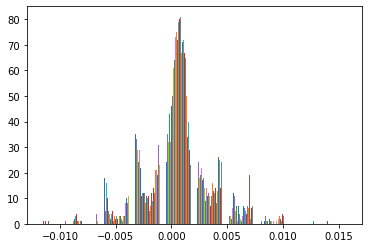

In [22]:
plt.hist(AR.masked)
plt.show()

## Test using equations to match flux

Want to confirm flux matches that expected from dimming and luminosity evolution.
- Dimming scales as the luminosity distance squared 

$F_o/F_e = (d_e/d_o)^2$

$F_e$ = Flux emitted 
$F_o$ = Flux observed 
$d$ = Luminosity distance


Luminosty increases as:
$M_o = \alpha z + M_e$


In [55]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

In [70]:
initial_z = 0.1
final_z = 0.2

initial_frame = areia.ObservationFrame(initial_z, pixelscale=0.06, exptime=5e4)
target_frame = areia.ObservationFrame(final_z, pixelscale=0.06, exptime=5e4)

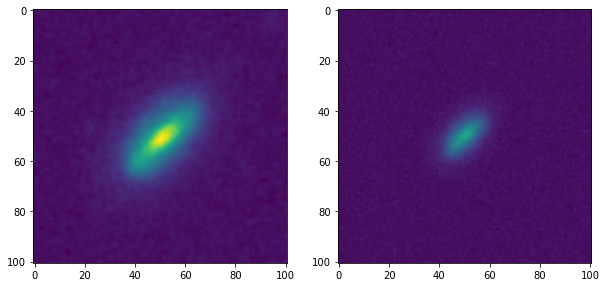

In [92]:
AR = areia.ArtificialRedshift(bright_galaxy, psf, None, initial_frame, target_frame)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
vmin = bright_galaxy.min()
vmax = bright_galaxy.max()
ax1.imshow(bright_galaxy, vmin=vmin, vmax=vmax)
ax2.imshow(AR.final, vmin=vmin, vmax=vmax)

In [93]:
AR.cutout.sum(), AR.final.sum()

(124.06184, 27.317993385015615)

In [94]:
F_e = AR.cutout.sum()
d_e = cosmo.luminosity_distance(initial_z)
d_o = cosmo.luminosity_distance(final_z)
dim = (d_e/d_o)**2

evo = 1*final_z
lum_evo = 10**(-0.4 * evo)

F_o = F_e * lum_evo * dim 

In [95]:
F_o

<Quantity 22.76227584>

In [99]:
AR.masked.sum()

4.5662274

In [100]:
F_o + AR.masked.sum()

<Quantity 27.32850327>